#### Описание данных

Данные предоставляются в формате JSON на каждой строке следующего содержания:

*   word – таргет (слово, которое хотел ввести пользователь)
*   curve
    *   x – массив координат X
    *   y – массив координат Y
    *   t – массив временных меток (время в миллисекундах)
    *   grid – формат раскладким
        *   grid\_name – название раскладки (default или extra)
        *   width – ширина раскладки
        *   height – высота раскладки
        *   keys – массив клавиш
            *   label – символ клавиши
            *   hitbox – область нажатия
                *   x – координата X верхнего левого угла
                *   y – координата Y верхнего левого угла
                *   w – ширина области
                *   h – высота области

У клавиш `enter`, `space`, `globe`, `toNumberState`, `backspace` нет ключа 'label', но есть одноименный ключ 'action'

* Кажется, из многих оюучающих примеров для default клавиатуры можно "деформировав пространство" сделать обучающие примеры для extra клавиатуры.
    * Интересно, нужно ли будет также деформировать время


In [1]:
from typing import List, Set, Optional, Dict
from collections import defaultdict
import json
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
TRAIN_DATASET_PATH = "../../data/data_separated_grid/train.jsonl"
VALID_DATASET_PATH = "../../data/data_separated_grid/valid__in_train_format.jsonl"
TEST_DATASET_PATH = "../../data/data_separated_grid/test.jsonl"

VOCAB_PATH = "../../data/data_separated_grid/voc.txt"
GRIDS_PATH = "../../data/data_separated_grid/gridname_to_grid.json"

In [3]:
with open(TRAIN_DATASET_PATH, 'rb') as f:
    n_train_lines = sum(1 for _ in f)
print(n_train_lines)
# result: 6000000
# takes 15 seconds

6000000


In [5]:
N_TRAIN_LINES = 6_000_000
N_VAL_LINES = N_TEST_LINES = 10_000

# Vocab

Словарь состоит из сивола  ```-``` и всех строчныхх букв русского алфавита, кроме ```ё```

Cловарь букв, генерируемых декодером, должен содержвать все буквы, кроме ё, а также ["-", "\<eos>", "\<pad>, "\<sos>"]

* pad не нужно генерировать, но его обязательно нужно уметь токенизировать: нужно использовать ignore\_index в CrossEntropyLoss.
* sos не должен генерироваться, но нужно уметь токенизировать, так как будет использоваться в качестве начального токена для декодера (нужен эмбеддинг)

In [6]:
from typing import Set


def get_unique_chars(vocab_path: str) -> Set[str]:
    """Given a path to vocabulary returns a set of unique characters in it"""
    with open(vocab_path, encoding="utf-8") as f:
        vocab = f.read()
    return set(vocab)

In [7]:
voc = get_unique_chars(VOCAB_PATH)

In [8]:
print(sorted(list(voc)))

['\n', '-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


In [9]:
'ё' in voc

False

In [10]:
import numpy as np
def get_max_output_len(vocab_path: str):
    """Given a path to vocabulary returns a maximum length of output sequence"""
    with open(vocab_path, encoding="utf-8") as f:
        vocab_str = f.read()
    vocab = vocab_str.split('\n')
    return vocab, np.argmax(np.array([len(word) for word in vocab])), max([len(word) for word in vocab])

In [11]:
vocab, argmax_word_len, max_word_len = get_max_output_len(VOCAB_PATH)

In [12]:
max_word_len

34

In [13]:
vocab[argmax_word_len]

'информационно-телекоммуникационной'

In [14]:
max_seq_len = max_word_len + 2  # with start and end tokens

In [15]:
if '\n' in voc:
    voc.remove('\n')

In [16]:
n_tokens = len(voc) + 2  # with start and end tokens

In [17]:
n_tokens, max_seq_len

(35, 36)

In [18]:
def get_word_len_to_count(dataset_path: str, 
                          total: Optional[int] = None) -> Dict[int, int]:
    """
    Given a path to dataset returns a dictionary with 
    word lengths as keys and their counts as values.
    """
    word_len_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total=total):
            data = json.loads(line)
            word = data['word']
            word_len_to_count[len(word)] += 1
    return word_len_to_count

In [19]:
train_word_len_counts = get_word_len_to_count(TRAIN_DATASET_PATH, total=N_TRAIN_LINES)
val_word_len_counts = get_word_len_to_count(VALID_DATASET_PATH, total=N_VAL_LINES)

100%|██████████| 10000/10000 [00:00<00:00, 14919.92it/s]


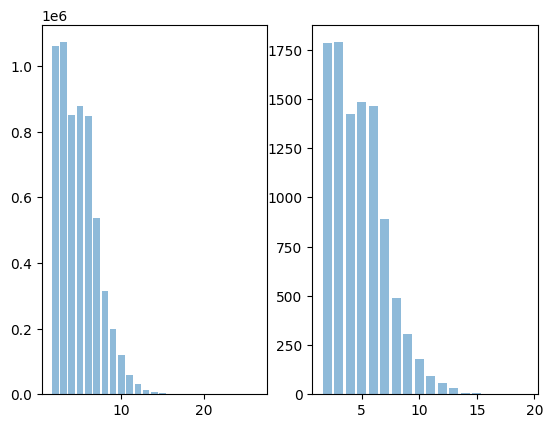

In [20]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)


train_ax.bar(train_word_len_counts.keys(), train_word_len_counts.values(), alpha=0.5, label='train')
val_ax.bar(val_word_len_counts.keys(), val_word_len_counts.values(), alpha=0.5, label='val')
plt.show()

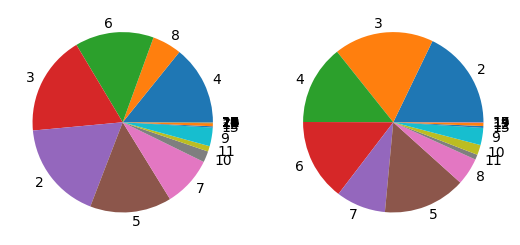

In [21]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)


train_ax.pie(train_word_len_counts.values(), labels = train_word_len_counts.keys())
val_ax.pie(val_word_len_counts.values(), labels = val_word_len_counts.keys()) 
plt.show()

In [36]:
train_word_len_counts_tuples = sorted([(l, n) for l, n in train_word_len_counts.items()])
val_word_len_counts_tuples = sorted([(l, n) for l, n in val_word_len_counts.items()])

In [39]:
def get_word_len_percentages(word_len_counts_tuples) -> Dict[int, float]:
    n_lines = sum([cnt for wrd_len, cnt in word_len_counts_tuples])
    return {wrd_len: cnt/n_lines*100 for wrd_len, cnt in word_len_counts_tuples}

In [50]:
def get_cumulative_prob_word_len(word_len_prcntg: Dict[int, float], 
                                 limit: int) -> float:
    cumulative_prob = 0
    for wrd_len, prcntg in word_len_prcntg.items():
        if wrd_len <= limit:
            cumulative_prob += prcntg
    return cumulative_prob

In [51]:
train_word_len_prcntg = get_word_len_percentages(train_word_len_counts_tuples)
train_word_len_prcntg

{2: 17.689583333333335,
 3: 17.881,
 4: 14.199,
 5: 14.628433333333332,
 6: 14.127766666666666,
 7: 8.969033333333334,
 8: 5.2577,
 9: 3.3300833333333335,
 10: 1.9960333333333333,
 11: 0.9729,
 12: 0.5462833333333333,
 13: 0.23900000000000002,
 14: 0.0948,
 15: 0.0401,
 16: 0.016033333333333333,
 17: 0.0059,
 18: 0.003733333333333333,
 19: 0.0010833333333333333,
 20: 0.0006000000000000001,
 21: 0.0006333333333333333,
 22: 0.00013333333333333334,
 23: 3.3333333333333335e-05,
 24: 8.333333333333333e-05,
 25: 3.3333333333333335e-05,
 26: 1.6666666666666667e-05}

In [52]:
val_word_len_prcntg = get_word_len_percentages(val_word_len_counts_tuples)
val_word_len_prcntg

{2: 17.84,
 3: 17.87,
 4: 14.24,
 5: 14.82,
 6: 14.66,
 7: 8.91,
 8: 4.88,
 9: 3.0700000000000003,
 10: 1.7999999999999998,
 11: 0.91,
 12: 0.5499999999999999,
 13: 0.33,
 14: 0.04,
 15: 0.06,
 17: 0.01,
 19: 0.01}

Распределения похожи. В обоих датасетах есть очен длииные слова (порядка 20 букв), однако, слова не длинне 11 букв составляют 99%, а слова не длиннее 7 букв составляют 88%

In [71]:
round(
    get_cumulative_prob_word_len(train_word_len_prcntg, 11), 2)

99.05

In [72]:
round(
    get_cumulative_prob_word_len(val_word_len_prcntg, 11), 2)

99.0

In [79]:
def get_word_len_pie_chart_dict(word_len_prcntg: Dict[int, float], 
                                limit: int
                                ) -> Dict[str, float]:
    word_len_pychart_dict = {}

    ommited_range = [float('inf'), limit]
    ommited_cumulative_prcntg = 0

    for word_len, prcntg in word_len_prcntg.items():
        if word_len <= limit:
            word_len_pychart_dict[f"{word_len}"] = prcntg
        else:
            ommited_cumulative_prcntg += prcntg
            if word_len < ommited_range[0]:
                ommited_range[0] = word_len
            if word_len > ommited_range[1]:
                ommited_range[1] = word_len

    word_len_pychart_dict[f"({ommited_range[0]}-{ommited_range[1]})"] = ommited_cumulative_prcntg

    return word_len_pychart_dict

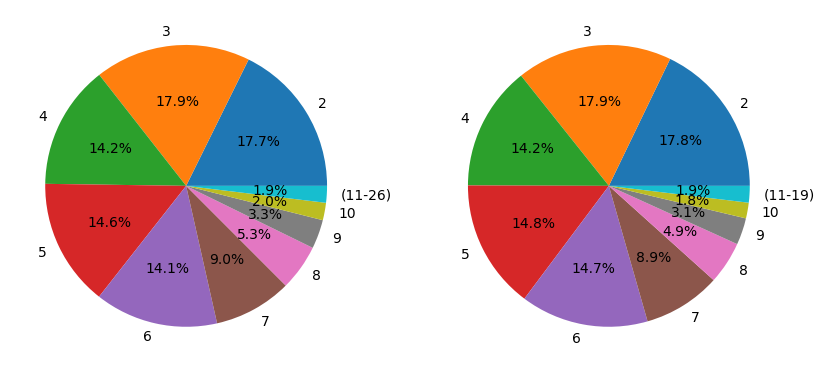

In [104]:
fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(10)
fig.set_figheight(5)

limit = 10

train_word_len_pychart_dict = get_word_len_pie_chart_dict(train_word_len_prcntg, limit)
val_word_len_pychart_dict = get_word_len_pie_chart_dict(val_word_len_prcntg, limit)

train_ax.pie(train_word_len_pychart_dict.values(), labels = train_word_len_pychart_dict.keys(), autopct='%1.1f%%')
val_ax.pie(val_word_len_pychart_dict.values(), labels = val_word_len_pychart_dict.keys(), autopct='%1.1f%%')
plt.show()

In [25]:
# from typing import List, Optional

# def get_trj_seq_lens(dataset_path: str, total: Optional[int] = None):
#     """Given a path to dataset returns a list of trajectory lengths"""
#     seq_lens = []
#     with open(dataset_path, encoding="utf-8") as f:
#         for line in tqdm(f, total = total):
#             line_data = json.loads(line)
#             trj_len = len(line_data['curve']['x'])
#             seq_lens.append(trj_len)
#     return seq_lens
            

In [27]:
def get_traj_len_to_count(dataset_path: str, total: Optional[int] = None) -> Dict[int, int]:
    """Given a path to dataset returns a dictionary where keys are trajectory lengths and values are their counts"""
    traj_len_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            trj_len = len(line_data['curve']['x'])
            traj_len_to_count[trj_len] += 1
    return traj_len_to_count

In [46]:
train_traj_len_to_count = get_traj_len_to_count(TRAIN_DATASET_PATH, total = 6_000_000)
val_traj_len_to_count = get_traj_len_to_count(VALID_DATASET_PATH, total = 10_000)
test_traj_len_to_count = get_traj_len_to_count(TEST_DATASET_PATH, total = 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 28650.42it/s]


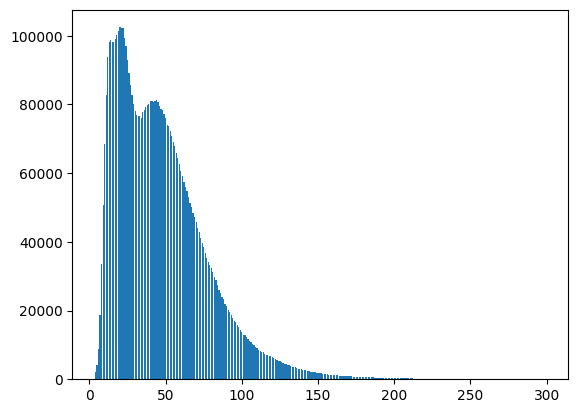

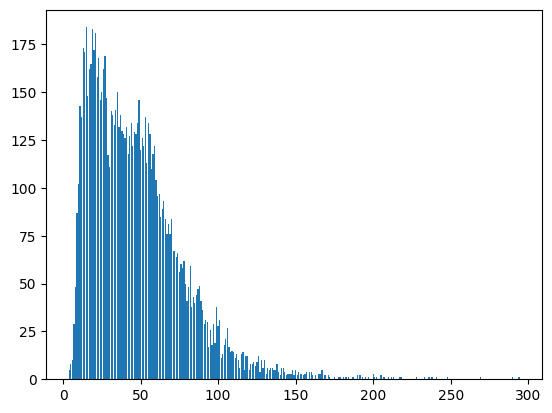

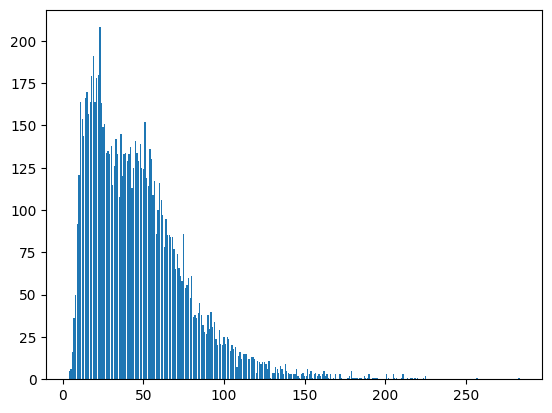

In [50]:
plt.bar(train_traj_len_to_count.keys(), train_traj_len_to_count.values())
plt.show()

plt.bar(val_traj_len_to_count.keys(), val_traj_len_to_count.values())
plt.show()


plt.bar(test_traj_len_to_count.keys(), test_traj_len_to_count.values())
plt.show()


In [51]:
train_seq_lens = list(train_traj_len_to_count.keys())
val_seq_lens = list(val_traj_len_to_count.keys())
test_seq_lens = list(test_traj_len_to_count.keys())

In [52]:
max(train_seq_lens), max(val_seq_lens), max(test_seq_lens)

(299, 294, 283)

In [53]:
min(train_seq_lens), min(val_seq_lens), min(test_seq_lens)

(4, 4, 4)

In [67]:
def get_word_to_count(dataset_path: str, total: Optional[int] = None) -> Dict[str, int]:
    """Given a path to dataset returns a dictionary where keys are words and values are their counts"""
    word_to_count = defaultdict(int)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            word_to_count[word] += 1
    return word_to_count

In [68]:
train_word_to_count = get_word_to_count(TRAIN_DATASET_PATH, total = 6_000_000)
val_word_to_count = get_word_to_count(VALID_DATASET_PATH, total = 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 25250.19it/s]


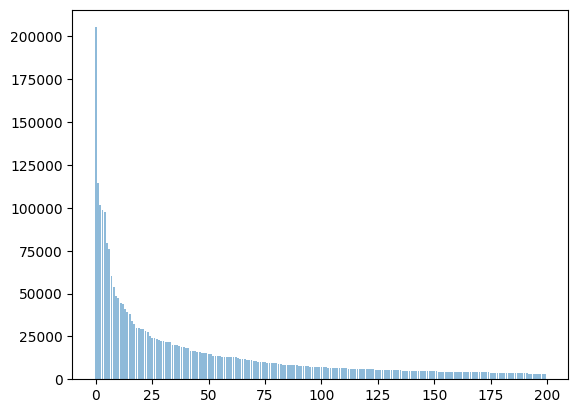

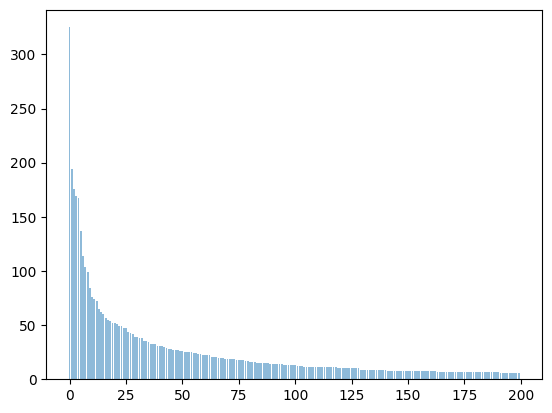

In [89]:
n_elements = 200  # If we take more elements, the line in the beginning will be ivisible

plt.bar(range(n_elements), sorted(list(train_word_to_count.values()), reverse=True)[:n_elements], alpha=0.5, label='train')
plt.show()
plt.bar(range(n_elements), sorted(list(val_word_to_count.values()), reverse=True)[:n_elements], alpha=0.5, label='val')
plt.show()

In [98]:
N_WORDS_IN_VOCAB = 500_000

covered_words_fraction = len(train_word_to_count) / N_WORDS_IN_VOCAB

print(f"Словарь покрыт тренировочным датасетом на {covered_words_fraction:.3%}")


Словарь покрыт тренировочным датасетом на 30.613%


In [101]:
# print most popular words

tupled_train_word_to_count = [(word, count) for word, count in train_word_to_count.items()]
tupled_train_word_to_count_sorted = sorted(tupled_train_word_to_count, key=lambda x: x[1], reverse=True)

print(*tupled_train_word_to_count_sorted[:100], sep='\n')

('не', 205313)
('ты', 114279)
('что', 101851)
('да', 98591)
('на', 97713)
('как', 79299)
('ну', 75709)
('это', 60136)
('все', 54085)
('нет', 48430)
('так', 47333)
('мне', 44526)
('меня', 44069)
('привет', 41236)
('хорошо', 39090)
('тебя', 38207)
('то', 34084)
('ок', 32531)
('еще', 30095)
('тебе', 29922)
('по', 29366)
('там', 29124)
('за', 28049)
('уже', 27854)
('вот', 25235)
('он', 24329)
('тоже', 23945)
('че', 23660)
('надо', 23160)
('есть', 22303)
('но', 22192)
('спасибо', 21889)
('же', 21606)
('если', 21489)
('только', 20147)
('где', 19854)
('или', 19726)
('просто', 19125)
('мы', 18759)
('будет', 18698)
('завтра', 18068)
('она', 18020)
('сегодня', 16609)
('когда', 16481)
('сейчас', 16226)
('можно', 15728)
('до', 15695)
('знаю', 15570)
('бы', 15537)
('хочу', 15289)
('ага', 15012)
('ладно', 14759)
('буду', 13766)
('давай', 13703)
('пока', 13420)
('вы', 13318)
('кто', 13279)
('дома', 13151)
('почему', 12880)
('понятно', 12777)
('для', 12743)
('может', 12729)
('сколько', 12720)
('от', 1

In [60]:
def get_word_len_to_swipe_lens(dataset_path: str, total: Optional[int] = None) -> Dict[int, List[int]]:
    """Given a path to dataset returns a dictionary where keys are word lengths and values are lists of swipe lengths"""
    word_len_to_swipe_len = defaultdict(list)
    with open(dataset_path, encoding="utf-8") as f:
        for line in tqdm(f, total = total):
            line_data = json.loads(line)
            word = line_data['word']
            swipe_len = len(line_data['curve']['x'])
            word_len_to_swipe_len[len(word)].append(swipe_len)
    return word_len_to_swipe_len

In [61]:
train_word_len_to_swipe_lens = get_word_len_to_swipe_lens(TRAIN_DATASET_PATH, total = 6_000_000)
val_word_len_to_swipe_len = get_word_len_to_swipe_lens(VALID_DATASET_PATH, total = 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 14935.81it/s]


In [62]:
def plot_word_len_to_swipe_len(word_len_to_swipe_len: Dict[int, List[int]]):
    for word_len, swipe_lens in word_len_to_swipe_len.items():
        plt.scatter([word_len] * len(swipe_lens), swipe_lens, alpha=0.1)
    plt.xlabel('Word length')
    plt.ylabel('Swipe length')
    plt.show()

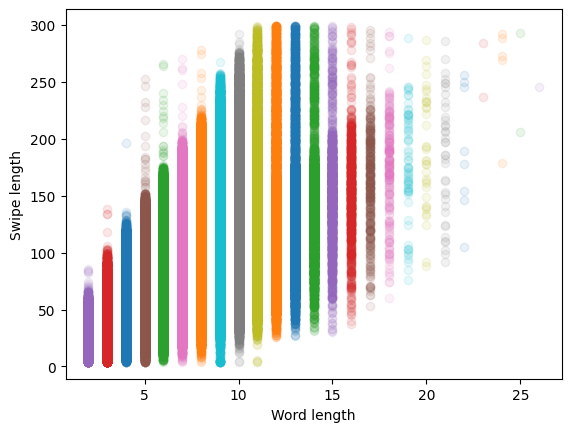

In [63]:
plot_word_len_to_swipe_len(train_word_len_to_swipe_lens)

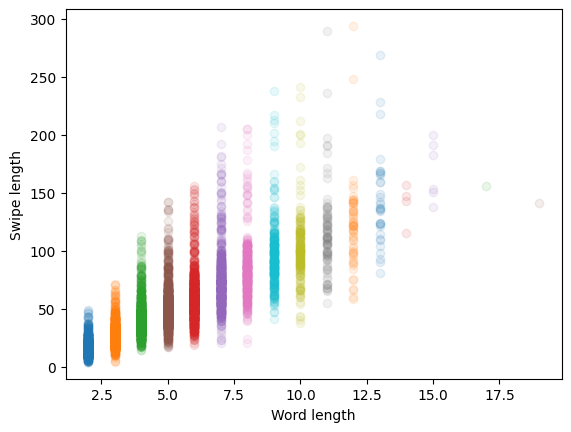

In [64]:
plot_word_len_to_swipe_len(val_word_len_to_swipe_len)

In [ ]:
# creates a sample dataset with 1000 lines from train dataset

def create_sample_dataset(dataset_path: str, sample_size: int, out_path: str):
    assert not os.path.exists(out_path), f"File {out_path} already exists!"
    with open(dataset_path, encoding="utf-8") as f, open(out_path, 'w', encoding="utf-8") as out_f:
        for i, line in tqdm(enumerate(f), total = sample_size):
            if i == sample_size:
                break
            out_f.write(line)


In [19]:
from typing import Optional
import os
import json

from tqdm import tqdm

def validation_dataset_to_train_format(dataset_path: str,
                                       ref_path: str,
                                       out_path: str,
                                       total: Optional[int] = None):
    
    if os.path.exists(out_path):
        raise ValueError(f"File {out_path} already exists!")
    
    with open(dataset_path, encoding="utf-8") as f:
        with open(ref_path, encoding="utf-8") as ref_f:
            with open(out_path, 'w', encoding="utf-8") as out_f:
                for line, ref_line in tqdm(zip(f, ref_f), total = total):
                    line_data = json.loads(line)
                    word = ref_line.rstrip('\n')
                    # This trick preserves the order of keys in the dict
                    # (which is not guaranteed). Preserving the order
                    # is not nessassary, but I decided to make the format
                    # of the dataset as close to the train dataset as possible.
                    # We could write line_data['word'] = word, but than 'word' 
                    # would be the last key in the dict.
                    line_data = {'word': word, **line_data}
                    json.dump(line_data,
                            out_f,
                            ensure_ascii=False,
                            separators=(',', ':'))
                    out_f.write('\n')

In [18]:
data_root = "../../data/data_separated_grid"
valid_dataset_path = os.path.join(data_root, "valid.jsonl")
valid_ref_path = os.path.join(data_root, "valid.ref")
valid_dataset_in_train_format_path = os.path.join(data_root, "valid__in_train_format.jsonl")

validation_dataset_to_train_format(
    valid_dataset_path,
    valid_ref_path,
    valid_dataset_in_train_format_path,
    total = 10_000)

10000it [00:03, 2998.20it/s]                        


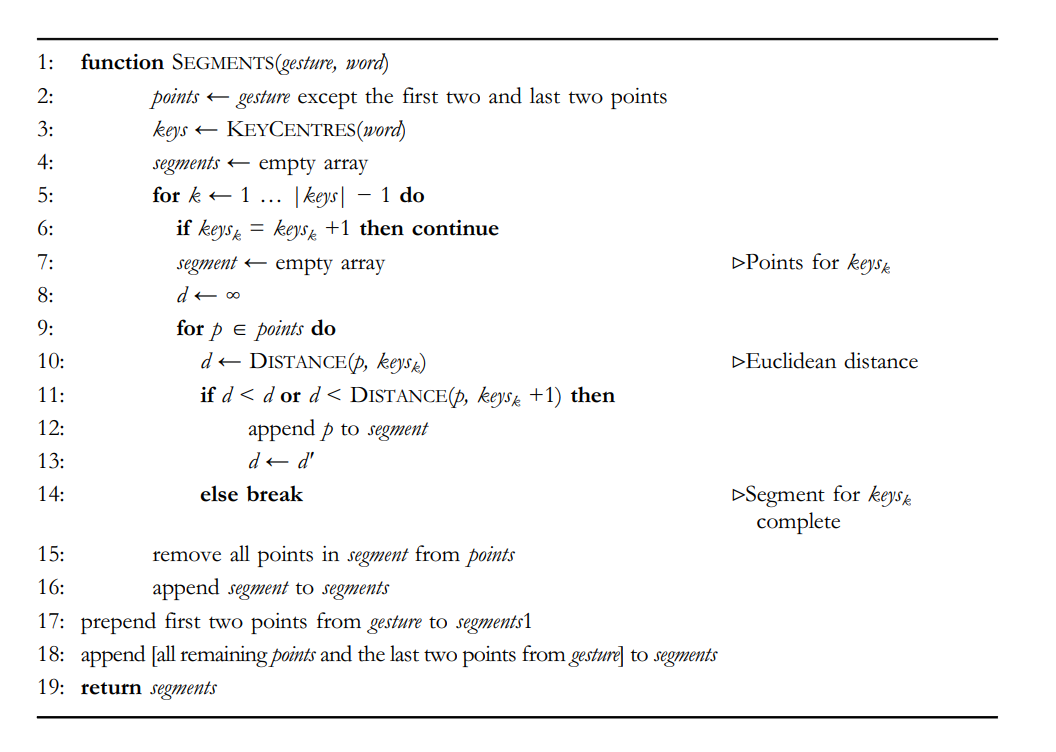

In [107]:
from typing import List, Tuple, Dict, Optional
import os
import json

from tqdm import tqdm

def monotoniacally_increases(time: List[int]) -> bool:
    for i, t in enumerate(time[1:], 1):
        if t <= time[i-1]:
            return False
    return True


def get_kb_key_center(hitbox: Dict[str, int]) -> float:
    x = hitbox['x'] + hitbox['w'] / 2
    y = hitbox['y'] + hitbox['h'] / 2
    return x, y


def distance(x1, y1, x2, y2) -> float:
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5


def points_not_too_far(x_list: List[int],
                       y_list: List[int],
                       kb_keys: dict,
                       max_dist: int) -> bool:
    for x, y in zip(x_list, y_list):
        not_too_far = False
        for key in kb_keys:
            key_x, key_y = get_kb_key_center(key['hitbox'])
            dist = distance(x, y, key_x, key_y)
            if dist < max_dist:
                not_too_far = True
                break
        if not not_too_far:
            return False
    return True  


def get_label2key(kb_keys: dict,
                  substitutions: dict = None) -> dict:
    """
    Arguments:
    ----------
    substitutions: dict
        Dict with keys being labels that are may be absent in grid
        and values being labels that should be used instead. 
        For example, {'ъ': 'ь', 'ё': 'е'}. If there is no 'ё' in grid,
        users swipes over 'е' instead.
    """
    if substitutions is None:
        substitutions = {'ъ': 'ь', 'ё': 'е'}

    label2key = {}
    for key in kb_keys:
        if 'label' not in key:
            continue
        label2key[key['label']] = key  # since i don't plan edditing keys, i don do keys.copy()
    for potentially_missing_label in substitutions.keys():
        if potentially_missing_label not in label2key:
            label2key[potentially_missing_label] = label2key[substitutions[potentially_missing_label]]
    return label2key


def get_segments(tdt_word: str,
                 x_list: List[int],
                 y_list: List[int],
                 label2key: Dict[str, dict]) -> List[Tuple[int, int]]:
    segments = []

    points = list(zip(x_list[2:-2], y_list[2:-2]))
    # print(points)
    p_i = 0

    keys = []
    for c in tdt_word:
        if c not in label2key:
            if c not in ['-']:
                print(f"Warning: `{c}` not in label2key")
            continue
        keys.append(get_kb_key_center(label2key[c]['hitbox']))

    # keys = [get_kb_key_center(label2key[c]['hitbox']) for c in tdt_word]
    
    for k_i, k in enumerate(keys[:-1]):
        if k == keys[k_i + 1]:
            continue
        segment = []
        prev_d = float('inf')

        k_x, k_y = k
        next_k_x, next_k_y = keys[k_i + 1]
        
        for x, y in points[p_i:]:
            d = distance(x, y, k_x, k_y)
            if d < prev_d or d < distance(x, y, next_k_x, next_k_y):
                segment.append((x, y))
                prev_d = d
            else:
                break
        segments.append(segment)
        p_i += len(segment)  # remove all points in segment from points

    if not segments:  
        # The word had of only one unique charracter.
        # Example: 'ее' which is a way to type 'её'.
        segments.append(list(zip(x_list, y_list)))
        return segments

    segments[0] = list(zip(x_list[:2], y_list[:2])) + segments[0]
    last_two_points = list(zip(x_list[-2:], y_list[-2:]))
    # points[p_i:].extend(last_two_points) is None :(
    segments.append(points[p_i:] + last_two_points)
    return segments


def n_segments_is_correct(tgt_word, segments):
    # тут не учтено, что в слове нужно произвести замены (например, 'ъ' на 'ь', 'ё' на 'е')
    # а также удалить пунктуацию (вроде бы только дефис)
    # причем удаление и замены нужно делать до того, как делать colapsed word,
    # иначе примеры вроде из-за будут ломать проверку
    word_without_hyphen = ""
    for c in tgt_word:
        if c != '-':
            word_without_hyphen += c
    
    collapsed_word = ""
    for i, c in enumerate(word_without_hyphen):
        if (i < (len(word_without_hyphen) - 1) and c == word_without_hyphen[i+1]):
            continue
        collapsed_word += c

    if len(segments) != len(collapsed_word):
        print(collapsed_word)

    return len(segments) == len(collapsed_word)



def over_two_points_in_each_segment(tgt_word: str,
                                    x: List[int],
                                    y: List[int],
                                    label2key: dict) -> bool:
    threshold_len = 2
    segments = get_segments(tgt_word, x, y, label2key)

    if not n_segments_is_correct(tgt_word, segments):
        print(f"Warning: n_segments = {len(segments)} for {tgt_word} and {segments}")
    
    for segment in segments:
        if len(segment) < threshold_len:
            return False
    return True


def create_dataset_without_errors(dataset_path: str,
                                  out_path: str,
                                  max_dist: int,
                                  grids: Dict[str, dict] = None,
                                  total: Optional[int] = None) -> List[Tuple[int, str]]:
    """
    Creates a version of a given dataset with invalid data filtered out.

    Arguments:
    ----------
    grids: str
        Dict with `grid names` as keys and `grids` as values.
        If grids is None
            it's supposed that the dataset is in original
            format (curves in the dataset don't have
            grid_name attribute, but have grid attribute with
            full grid information).
        Else
            Curves have grid_name attribute and don't have 
            grid attribute
    """
    if os.path.exists(out_path):
        raise ValueError(f"File {out_path} already exists!")
    
    error_idxs = []
    with open(dataset_path, encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f), total = total):
            line_data = json.loads(line)

            c = line_data['curve']
            x, y, t = c['x'], c['y'], c['t']
            if grids is not None:
                kb_keys = grids[c['grid_name']]['keys']
            else:
                kb_keys = c['grid']['keys']

            has_error = (not monotoniacally_increases(t) or
                         not points_not_too_far(x, y, kb_keys, max_dist) or
                         not over_two_points_in_each_segment(
                             line_data['word'], x, y, get_label2key(kb_keys))
            )

            if has_error:
                error_idxs.append((i, line))
                continue

            with open(out_path, 'a', encoding="utf-8") as out_f:
                out_f.write(line)
    
    return error_idxs




def create_dataset_without_errors_except_segments_check(dataset_path: str,
                                                        out_path: str,
                                                        max_dist: int,
                                                        grids: Dict[str, dict] = None,
                                                        total: Optional[int] = None) -> List[int]:
    if os.path.exists(out_path):
        raise ValueError(f"File {out_path} already exists!")
    
    error_idxs = []
    with open(dataset_path, encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f), total = total):
            line_data = json.loads(line)

            c = line_data['curve']
            x, y, t = c['x'], c['y'], c['t']
            if grids is not None:
                kb_keys = grids[c['grid_name']]['keys']
            else:
                kb_keys = c['grid']['keys']

            has_error = (not monotoniacally_increases(t) or
                         not points_not_too_far(x, y, kb_keys, max_dist)
            )

            if has_error:
                error_idxs.append(i)
                continue

            with open(out_path, 'a', encoding="utf-8") as out_f:
                out_f.write(line)
    
    return error_idxs

In [2]:
data = json.loads('{"word":"ее","curve":{"x":[437,437,434,433,433],"y":[60,60,60,59,59],"t":[0,7,76,461,503],"grid_name":"default"}}')

c = data['curve']

grids_path = "../../data/data_separated_grid/gridname_to_grid.json"
with open(grids_path , encoding="utf-8") as f:
    grids = json.load(f)

segments = get_segments(data['word'], c['x'], c['y'], get_label2key(grids[c['grid_name']]['keys']))

segments, data['word']

([[(437, 60), (437, 60), (434, 60), (433, 59), (433, 59)]], 'ее')

In [44]:
# create_sample_dataset(
#     "../../data/data_separated_grid/train__default_only.jsonl",
#     1000,
#     "../../data/data_separated_grid/sample_deleteme__default_only.jsonl")

100%|██████████| 1000/1000 [00:00<00:00, 55549.28it/s]


In [105]:
import json

from tqdm import tqdm



with open(GRIDS_PATH, encoding="utf-8") as f:
    grids = json.load(f)

data_examples = []

with open(VALID_DATASET_PATH, encoding="utf-8") as f:
    for line in tqdm(f):
        data_examples.append(json.loads(line))

0it [00:00, ?it/s]

10000it [00:01, 9487.71it/s]


In [128]:
data = data_examples[6]
c = data['curve']
segments = get_segments(data['word'], c['x'], c['y'], get_label2key(grids[c['grid_name']]['keys']))

In [129]:
print(data['word'])

скинь


In [130]:
sum(len(s) for s in segments), len(c['x'])

(40, 40)

In [131]:
len(segments), len(data['word'])

(5, 5)

In [132]:
print(list(zip(c['x'], c['y'])))
print(segments)

[(352, 392), (352, 392), (351, 391), (348, 304), (351, 205), (348, 126), (342, 67), (337, 39), (336, 19), (334, 12), (334, 10), (345, 28), (385, 114), (424, 195), (454, 261), (485, 316), (505, 349), (523, 382), (533, 395), (538, 401), (539, 403), (545, 394), (550, 322), (532, 219), (520, 120), (518, 67), (523, 42), (526, 31), (529, 28), (539, 30), (566, 75), (593, 144), (622, 229), (650, 301), (673, 338), (697, 374), (719, 397), (741, 418), (750, 425), (750, 425)]
[[(352, 392), (352, 392), (351, 391), (348, 304)], [(351, 205), (348, 126), (342, 67), (337, 39), (336, 19), (334, 12), (334, 10), (345, 28), (385, 114), (424, 195)], [(454, 261), (485, 316), (505, 349), (523, 382), (533, 395), (538, 401), (539, 403), (545, 394), (550, 322)], [(532, 219), (520, 120), (518, 67), (523, 42), (526, 31), (529, 28), (539, 30), (566, 75), (593, 144), (622, 229)], [(650, 301), (673, 338), (697, 374), (719, 397), (741, 418), (750, 425), (750, 425)]]


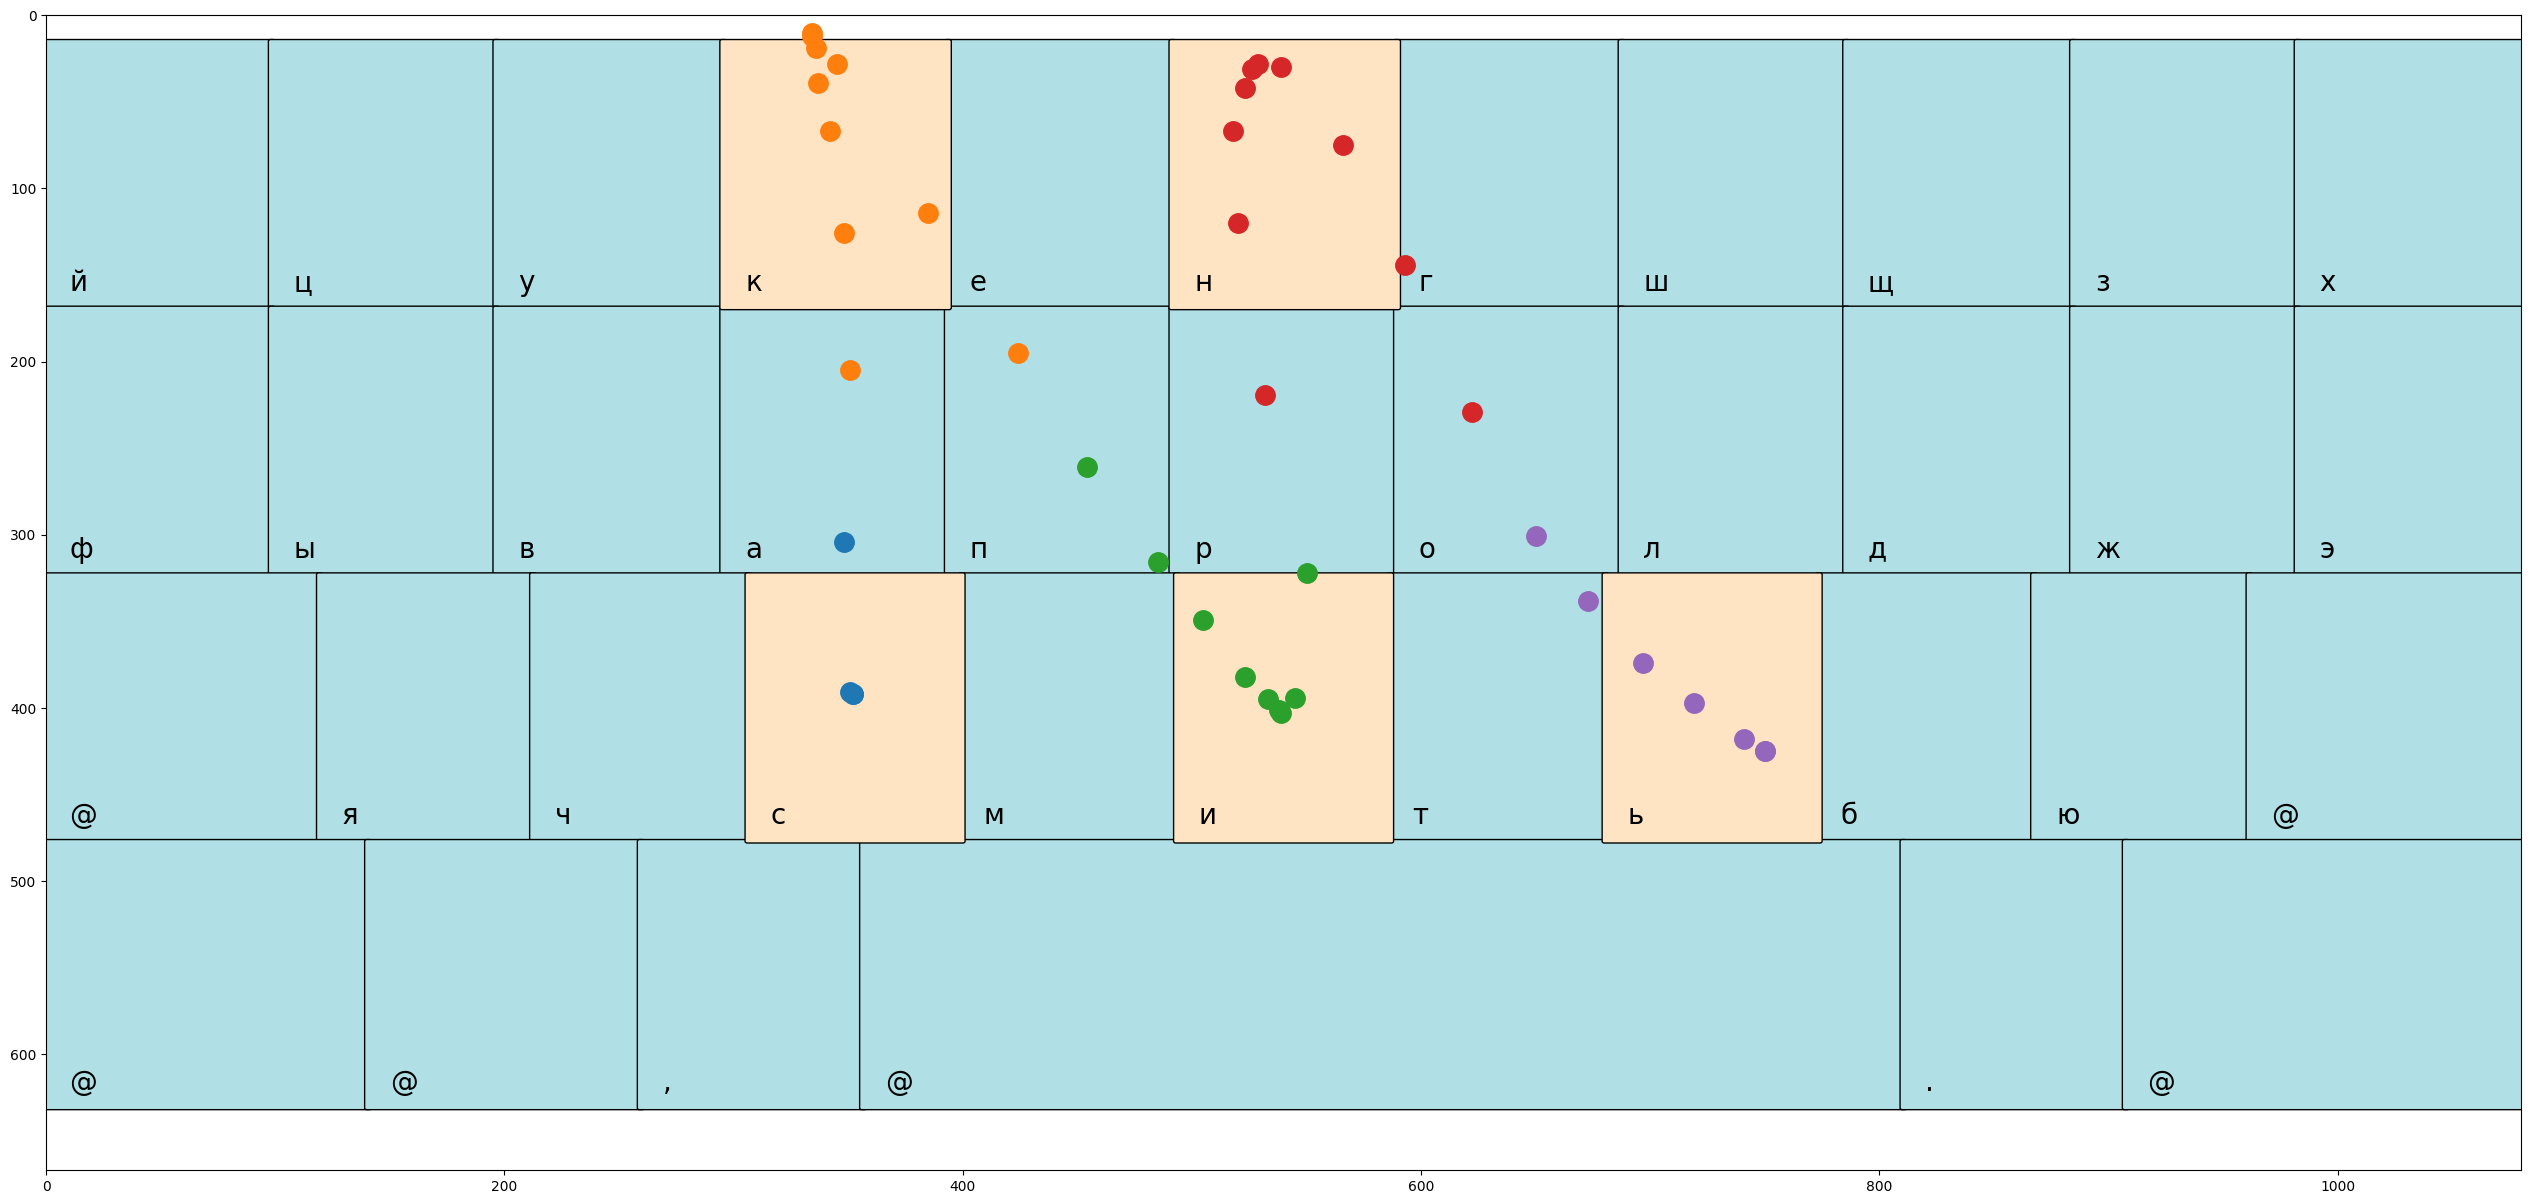

In [144]:
import sys; import os; sys.path.insert(1, os.path.join(os.getcwd(), ".."))


from keyboard_start.tools.viz import plot_keyboard
from grid_processing_utils import get_grid, get_wh


grid = get_grid(data['curve']['grid_name'], GRIDS_PATH)


width, height = get_wh(grid)

fig, ax = plot_keyboard(grid, word = data['word'])


for segment in segments:
    segment = np.array(segment)
    ax.plot(segment[:, 0], segment[:, 1], 'o', markersize=14)


ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()

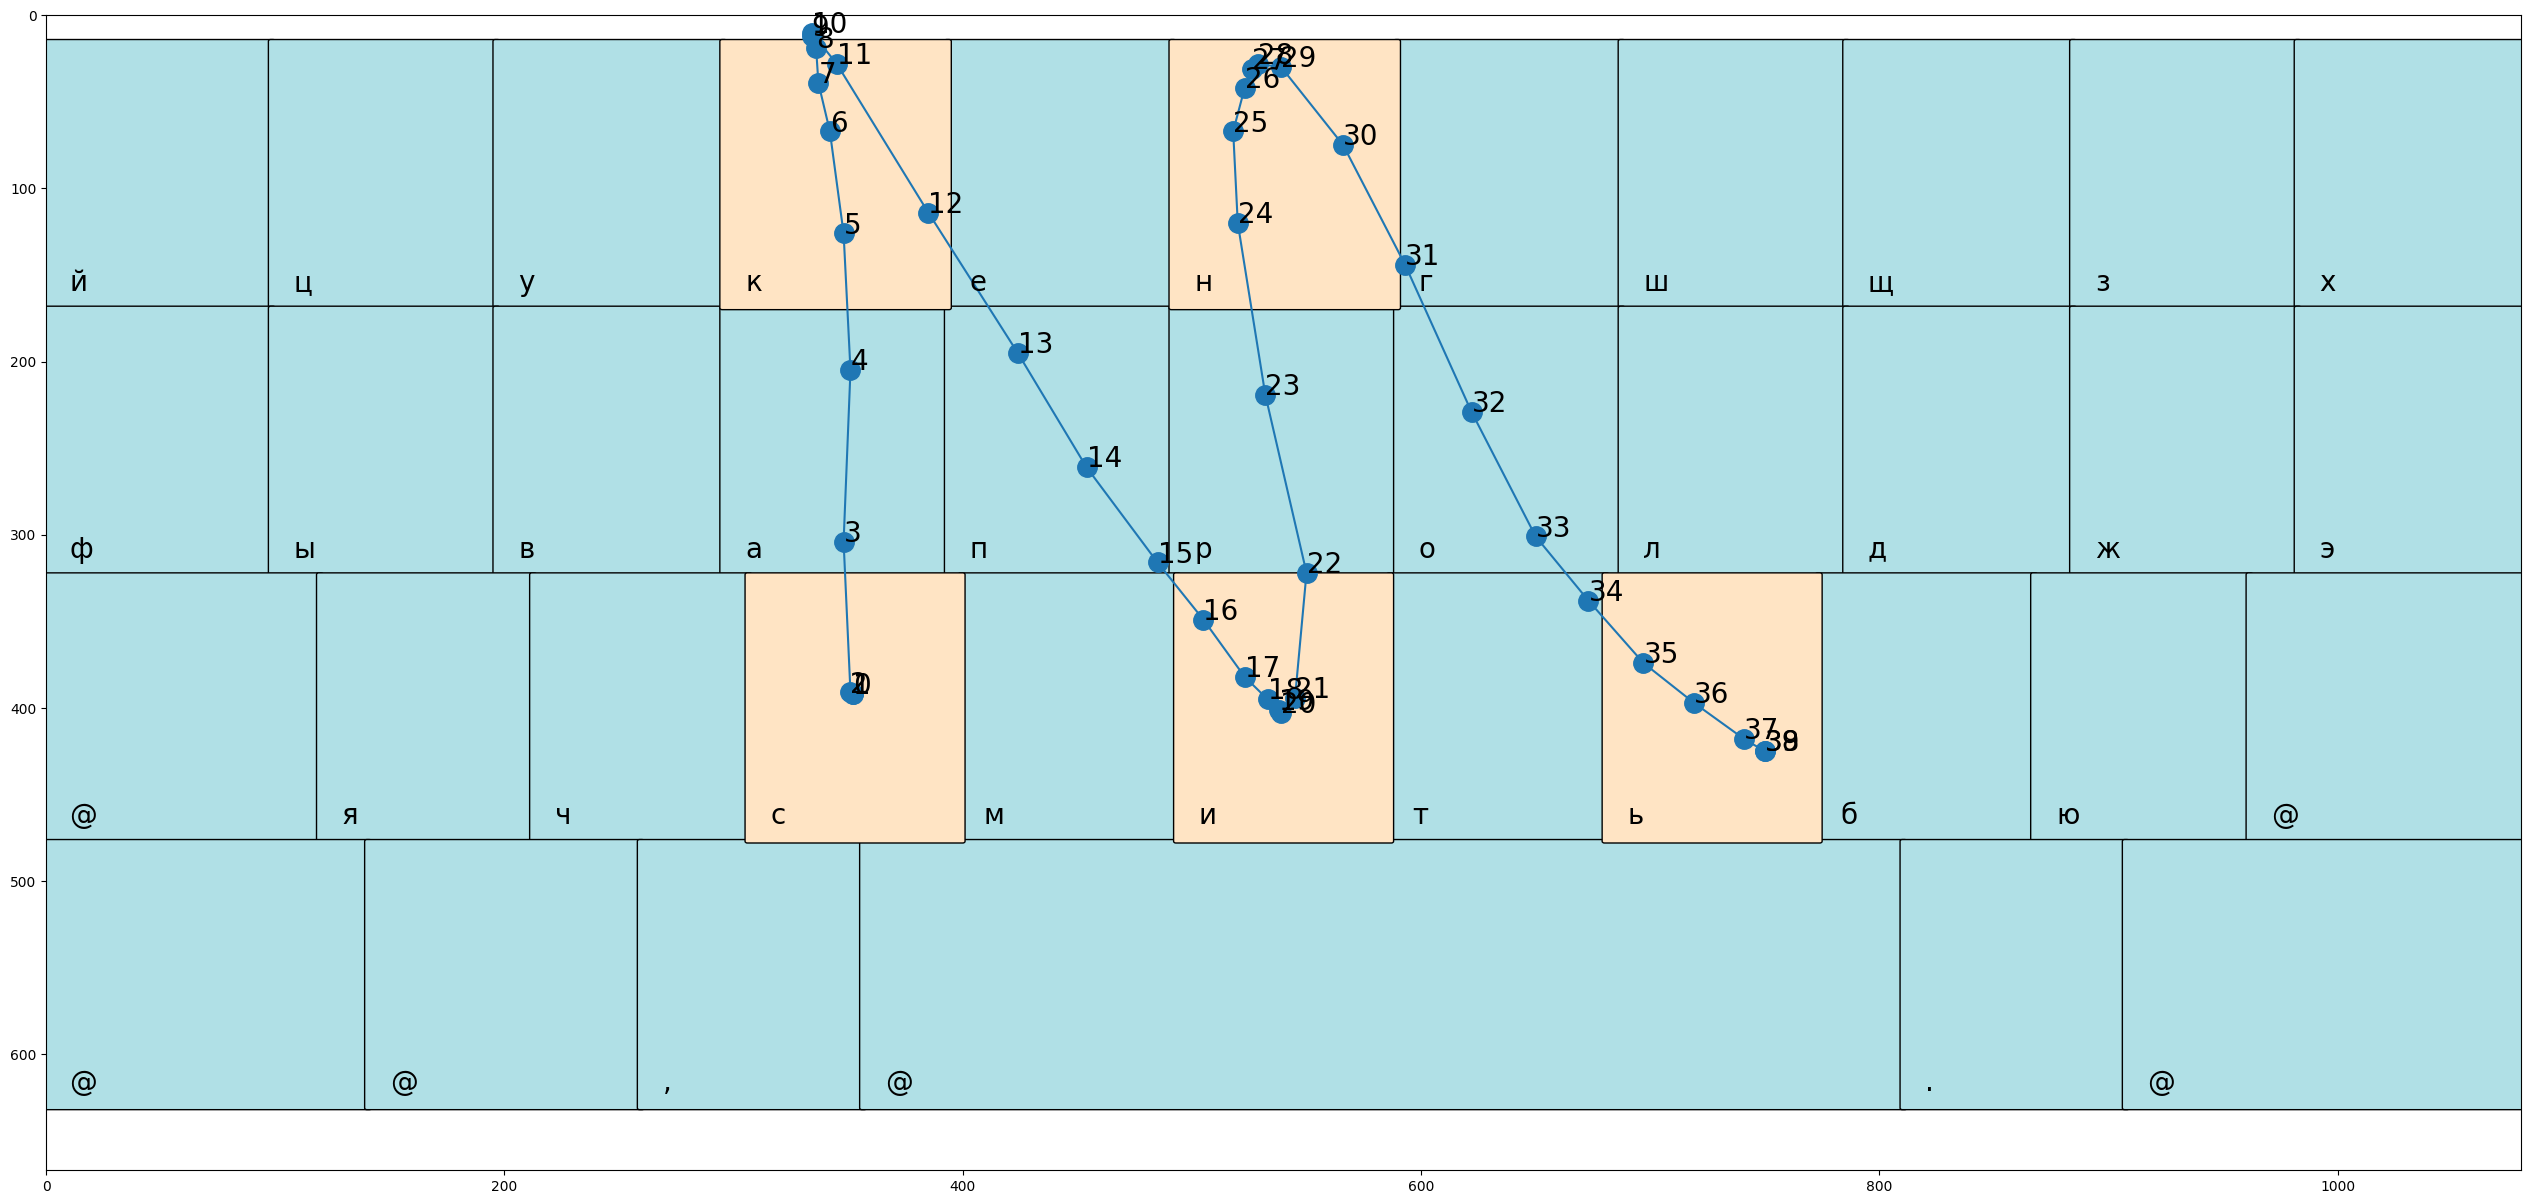

In [153]:
fig, ax = plot_keyboard(grid, word = data['word'])


# ax.scatter(c['x'], c['y'])
ax.plot(c['x'], c['y'], '-o', markersize=14)
for i, (x, y) in enumerate(zip(c['x'], c['y'])):
    ax.text(x,y,i, fontsize=20)

ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()

In [135]:
label2key = get_label2key(grids['default']['keys'])
max_dist  = distance(*get_kb_key_center(label2key['ф']['hitbox']),
         *get_kb_key_center(label2key['ц']['hitbox'])
)
max_dist

182.53766734567415

In [136]:
get_kb_key_center(label2key['й']['hitbox'])

(49.5, 92.0)

In [137]:
get_kb_key_center(label2key['ф']['hitbox'])

(49.5, 246.0)

In [138]:
get_kb_key_center(label2key['ц']['hitbox'])

(147.5, 92.0)

In [139]:
grids['default']['height'], grids['default']['width']

(667, 1080)

In [2]:
from datetime import datetime
cur_time = "{:%Y_%m_%d__%H_%M_%S}".format(datetime.now())


grids_path = "../../data/data_separated_grid/gridname_to_grid.json"
with open(grids_path , encoding="utf-8") as f:
    grids = json.load(f)


label2key = get_label2key(grids['default']['keys'])
max_dist  = distance(
    *get_kb_key_center(label2key['ф']['hitbox']),
    *get_kb_key_center(label2key['ц']['hitbox'])
)

errors = create_dataset_without_errors(
    dataset_path="../../data/data_separated_grid/train__default_only.jsonl",
    out_path=f"../../data/data_separated_grid/train__default_only_no_errors__{cur_time}.jsonl",
    max_dist = max_dist,
    grids = grids,
    total = 5_626_340)

  0%|          | 40/5626340 [00:00<3:59:07, 392.14it/s]

100%|██████████| 5626340/5626340 [2:40:00<00:00, 586.04it/s]  


In [4]:
len(errors)

388756

In [5]:
print(len(errors)/5_626_340*100)

6.909571764237497


In [8]:
import pickle

errors_List_save_path = "../../data/data_separated_grid/train__default_only__errors_list.pkl"

with open(errors_List_save_path, 'wb') as f:
    pickle.dump(errors, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(errors_List_save_path, 'rb') as f:
    errors_loaded = pickle.load(f)

print(errors == errors_loaded)

True


In [26]:
from datetime import datetime
cur_time = "{:%Y_%m_%d__%H_%M_%S}".format(datetime.now())

data_root = "../../data/data_separated_grid"
grids_path = os.path.join(data_root, "gridname_to_grid.json")
with open(grids_path , encoding="utf-8") as f:
    grids = json.load(f)


label2key = get_label2key(grids['extra']['keys'])
max_dist  = distance(
    *get_kb_key_center(label2key['ф']['hitbox']),
    *get_kb_key_center(label2key['ц']['hitbox'])
)

errors = create_dataset_without_errors(
    dataset_path=os.path.join(data_root, "train__extra_only.jsonl"),
    out_path=os.path.join(data_root, f"train__extra_only_no_errors__{cur_time}.jsonl"),
    max_dist = max_dist,
    grids = grids,
    total = 373_660)

  0%|          | 80/626340 [00:00<52:26, 199.05it/s]

 60%|█████▉    | 373660/626340 [39:56<27:00, 155.92it/s]  


In [27]:
len(errors), len(errors)/373_660*100

(24488, 6.553551356848472)

In [28]:
import pickle

errors_List_save_path = os.path.join(data_root, "train__extra_only__errors_list.pkl")

with open(errors_List_save_path, 'wb') as f:
    pickle.dump(errors, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(errors_List_save_path, 'rb') as f:
    errors_loaded = pickle.load(f)

print(errors == errors_loaded)

True
